In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn

In [2]:
def print_simple_number(truth_table,object_type):
    total_N = len(truth_table)
    good_N = len(truth_table[truth_table['best_quality']>=2.5])
    very_good_N = len(truth_table[truth_table['best_quality']==4])
    tmp_table = truth_table.loc[truth_table['best_quality']>=2.5]
    number_of_consistent_z = len(tmp_table.loc[abs(tmp_table['best_z']-tmp_table['Redrock_z'])/(1+tmp_table['best_z'])<0.0033])
    
    print('Number of',object_type,':',total_N)
    print('Number of ',object_type,'with quality>=2.5:',good_N, ' | fration=',good_N*1.0/total_N)
    print('Number of ',object_type,'with quality==4:',very_good_N, ' | fration=',very_good_N*1.0/total_N)
    print('Number of ',object_type,'with consistent z (with quality>=2.5):',number_of_consistent_z, '| fraction=',number_of_consistent_z/total_N)
   
    number_star = len(tmp_table.loc[tmp_table['best_spectype']=='STAR'])
    number_galaxy = len(tmp_table.loc[tmp_table['best_spectype']=='GALAXY'])
    number_qso = len(tmp_table.loc[tmp_table['best_spectype']=='QSO'])
    print('---------')  
    print('Fraction of objects with quality>=2.5')
    print('Star:',number_star*1.0/good_N)
    print('Galaxy:',number_galaxy*1.0/good_N)    
    print('QSO:',number_qso*1.0/good_N)

    plt.hist(truth_table['best_quality'],bins=8,range=(0,4))
    plt.ylabel('Number')
    plt.xlabel('Quality')
    plt.yscale('log')
    plt.xlim(0,4)
  

In [3]:
def plot_redshift_distribution(truth_table,object_type):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = [0,max(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'])]
    plt.hist(truth_table['best_z'],range=(x_range[0],x_range[1]),bins=20,color='b',label='All')
    plt.hist(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='orange',label='quality>=2.5')
    plt.hist(truth_table.loc[truth_table['best_quality']==4]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='g',label='quality=4')
    plt.yscale('log')
    plt.xlabel('Best z')
    plt.ylabel('Number')
    plt.legend()
    plt.title(object_type)
    
    plt.subplot(1,2,2)
    plt.scatter(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],truth_table.loc[truth_table['best_quality']>=2.5]['Redrock_z'],
                
                c=truth_table.loc[truth_table['best_quality']>=2.5]['best_quality'],cmap=cm.jet)
    plt.xlabel('Best z')
    plt.ylabel('Redrock z')
    plt.colorbar()

In [4]:
def plot_chi2_quality_distribution(truth_table):
    #plt.scatter(truth_table['best_quality'],truth_table['DELTACHI2'])
    #plt.ylim(1,100000)
    #plt.yscale('log')
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(np.log10(truth_table['DELTACHI2']),label='All',bins=8,range=(0,5),color='b')
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5))
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),)
    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1,2,2)
    
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']<2.5]['DELTACHI2']),color='grey',label='flag<2.5',bins=8,range=(0,5),histtype='step',lw=4)
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5),histtype='step',lw=4)
    #plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),histtype='step',lw=4)

    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()    
    
    
    
    

In [5]:
def give_me_ra_dec_object_with_property_cut(truth_table, property_name, cut, if_print=True):
    tmp_table = truth_table.loc[(truth_table[property_name]>=cut[0]) & (truth_table[property_name]<cut[1])]
    if if_print==True:
        for i_object in range(0,len(tmp_table)):
            print(tmp_table['TARGET_RA'].values[i_object],tmp_table['TARGET_DEC'].values[i_object])
    
    return tmp_table

In [6]:
# The filenames are tentative. We will change the filenames.
on_nersc=False
if on_nersc==True:
    dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Cascades/'
    BGS = pd.read_csv(dir+'BGS/'+'desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    LRG = pd.read_csv(dir+'LRG/'+'desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    ELG = pd.read_csv(dir+'ELG/'+'desi-vi_SV_cascades_combination_ELG_all_210521.csv')
    ELG['DELTACHI2']=ELG['Redrock_deltachi2']
    #ELG_80606 = pd.read_csv(dir+'ELG/'+'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv')
else:
    #dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Truth_tables/'
    LRG = pd.read_csv('/Users/blue/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV_VI_cascades/Cascades/LRG/output/desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    #LRG = pd.read_csv(dir+'desi-vi_LRG_tile80609_nightdeep_merged_all_210130.csv')
   

In [7]:
denali_all = Table.read('/Volumes/Elements/DESI/Denali/denali_alltiles_Allzinfo.fits')
denali_all = denali_all[denali_all['coadd_type']=='cumulative']
new_catalog_denali = denali_all['TARGETID','Z','subset','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','LAST_NIGHT',
                              'EFFTIME_BRIGHT','FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER'].to_pandas()

# LRG main z_deep<1.4 and non-repeatable redshifts

Number of LRG : 802
Number of  LRG with quality>=2.5: 754  | fration= 0.940149625935162
Number of  LRG with quality==4: 543  | fration= 0.6770573566084788
Number of  LRG with consistent z (with quality>=2.5): 638 | fraction= 0.7955112219451371
---------
Fraction of objects with quality>=2.5
Star: 0.09946949602122016
Galaxy: 0.8275862068965517
QSO: 0.07294429708222812


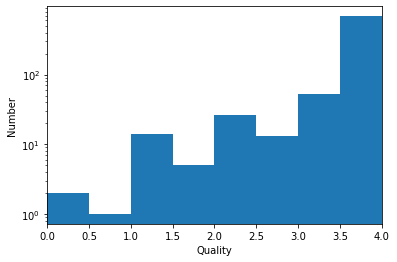

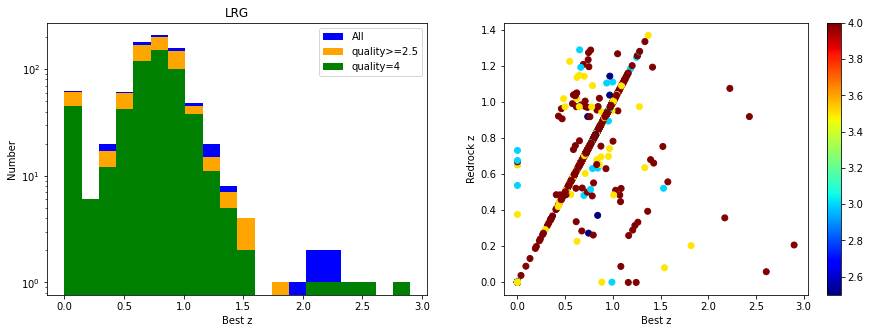

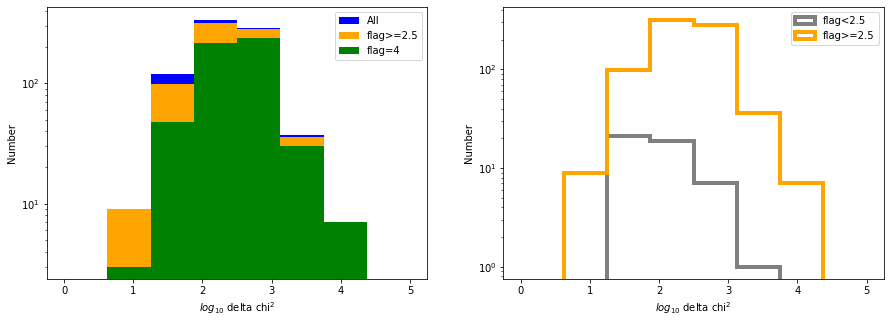

In [8]:
LRG_main = LRG[LRG['setting_name']=='sel0']
print_simple_number(LRG_main,'LRG')
plot_redshift_distribution(LRG_main,'LRG')
plot_chi2_quality_distribution(LRG_main)

In [9]:
catalog_LRG_match = LRG_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_cascades']==catalog_LRG_match['TILEID_denali']]
final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
final_match_catalog['Redrock_z']=final_match_catalog['Z']

<ipython-input-9-ed98acf17b44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
<ipython-input-9-ed98acf17b44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of LRG : 802
Number of  LRG with quality>=2.5: 754  | fration= 0.940149625935162
Number of  LRG with quality==4: 543  | fration= 0.6770573566084788
Number of  LRG with consistent z (with quality>=2.5): 641 | fraction= 0.7992518703241895
---------
Fraction of objects with quality>=2.5
Star: 0.09946949602122016
Galaxy: 0.8275862068965517
QSO: 0.07294429708222812


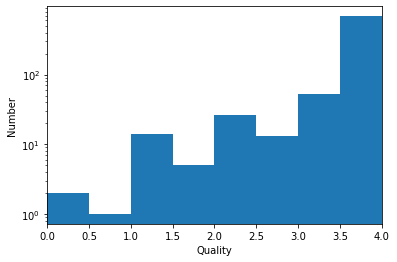

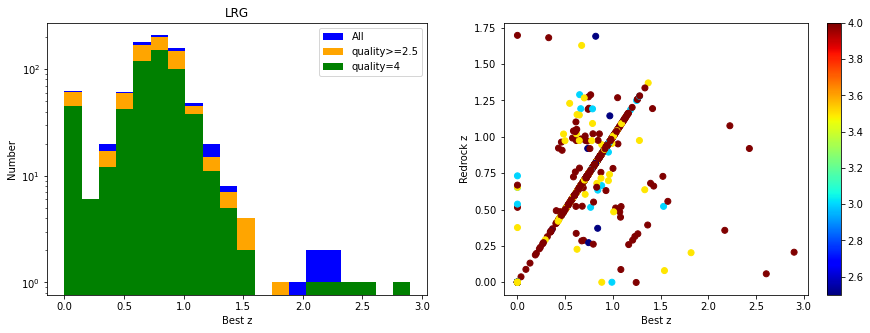

In [10]:
#final_match_catalog['Redrock_z']=final_match_catalog['Z']
print_simple_number(final_match_catalog,'LRG')
plot_redshift_distribution(final_match_catalog,'LRG')

In [12]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-12-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [13]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]
print(len(cut_catalog))

113


113
113


Text(0, 0.5, 'Best VI redshift')

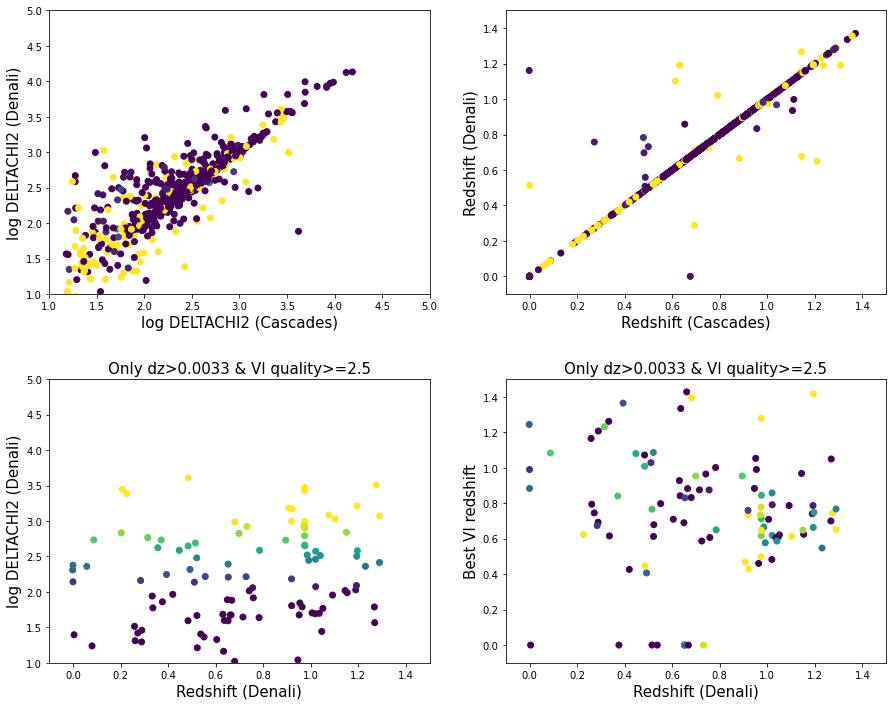

In [14]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,2,1)
plt.scatter(np.log10(final_match_catalog['DELTACHI2_cascades']),np.log10(final_match_catalog['DELTACHI2_denali']),c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(1,5)
plt.ylim(1,5)
plt.xlabel('log DELTACHI2 (Cascades)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,2)
plt.scatter(final_match_catalog['Z_cascades'],final_match_catalog['Z'],c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(-0.1,1.5)
plt.ylim(-0.1,1.5)
plt.xlabel('Redshift (Cascades)',fontsize=15)
plt.ylabel('Redshift (Denali)',fontsize=15)
plt.subplot(2,2,3)
plt.scatter(cut_catalog['Z'],np.log10(cut_catalog['DELTACHI2_denali']),c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.xlim(-0.1,1.5)
plt.ylim(1,5)
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,4)
plt.scatter(cut_catalog['Z'],cut_catalog['best_z'],c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlim(-0.1,1.5)
plt.ylim(-0.1,1.5)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('Best VI redshift',fontsize=15)

# LRG with z_deep>1.4

Number of LRG : 145
Number of  LRG with quality>=2.5: 107  | fration= 0.7379310344827587
Number of  LRG with quality==4: 73  | fration= 0.503448275862069
Number of  LRG with consistent z (with quality>=2.5): 30 | fraction= 0.20689655172413793
---------
Fraction of objects with quality>=2.5
Star: 0.06542056074766354
Galaxy: 0.35514018691588783
QSO: 0.5794392523364486


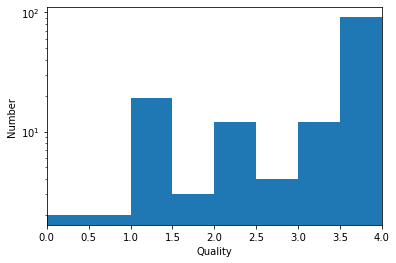

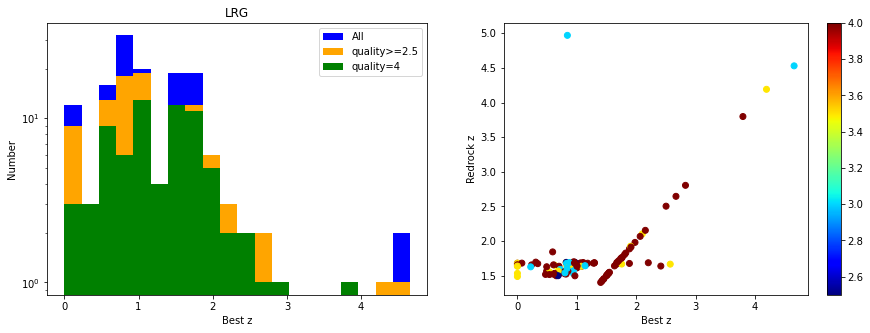

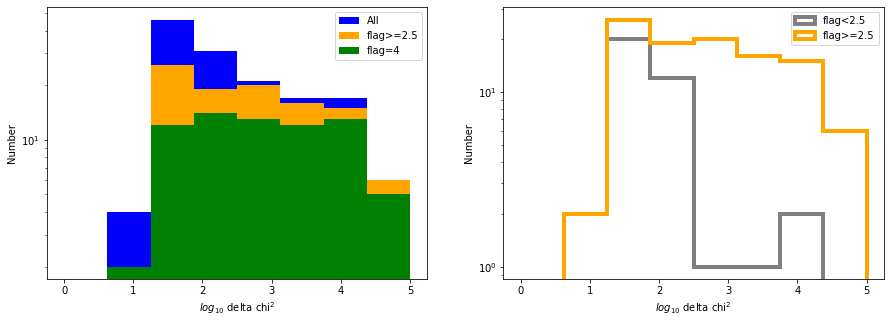

In [15]:
LRG_highz = LRG[LRG['setting_name']=='sel1']
print_simple_number(LRG_highz,'LRG')
plot_redshift_distribution(LRG_highz,'LRG')
plot_chi2_quality_distribution(LRG_highz)

In [16]:
catalog_LRG_match = LRG_highz.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))

In [17]:
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_cascades']==catalog_LRG_match['TILEID_denali']]

### Comparing the Denali redshift and the best z


<ipython-input-18-f5180071fb72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
<ipython-input-18-f5180071fb72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of LRG : 145
Number of  LRG with quality>=2.5: 107  | fration= 0.7379310344827587
Number of  LRG with quality==4: 73  | fration= 0.503448275862069
Number of  LRG with consistent z (with quality>=2.5): 42 | fraction= 0.2896551724137931
---------
Fraction of objects with quality>=2.5
Star: 0.06542056074766354
Galaxy: 0.35514018691588783
QSO: 0.5794392523364486


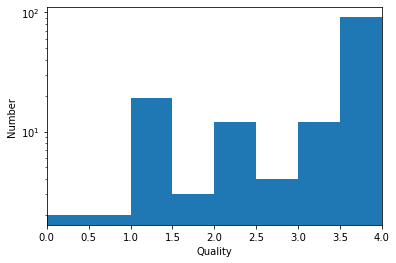

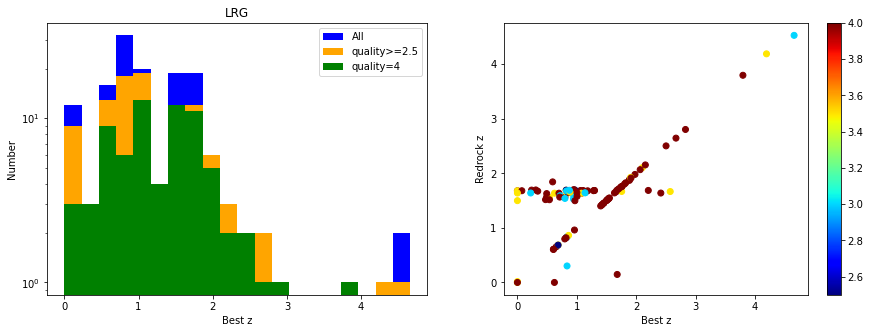

In [18]:
final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
final_match_catalog['Redrock_z']=final_match_catalog['Z']
print_simple_number(final_match_catalog,'LRG')
plot_redshift_distribution(final_match_catalog,'LRG')
#plot_chi2_quality_distribution(final_match_catalog)

In [19]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-19-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [20]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

In [22]:
len(np.array(cut_catalog['TILEID_denali']))
#for i in range(0,112):
#    print(np.array(cut_catalog['TARGET_RA'])[i],np.array(cut_catalog['TARGET_DEC'])[i])

65

65
65


Text(0, 0.5, 'Best VI redshift')

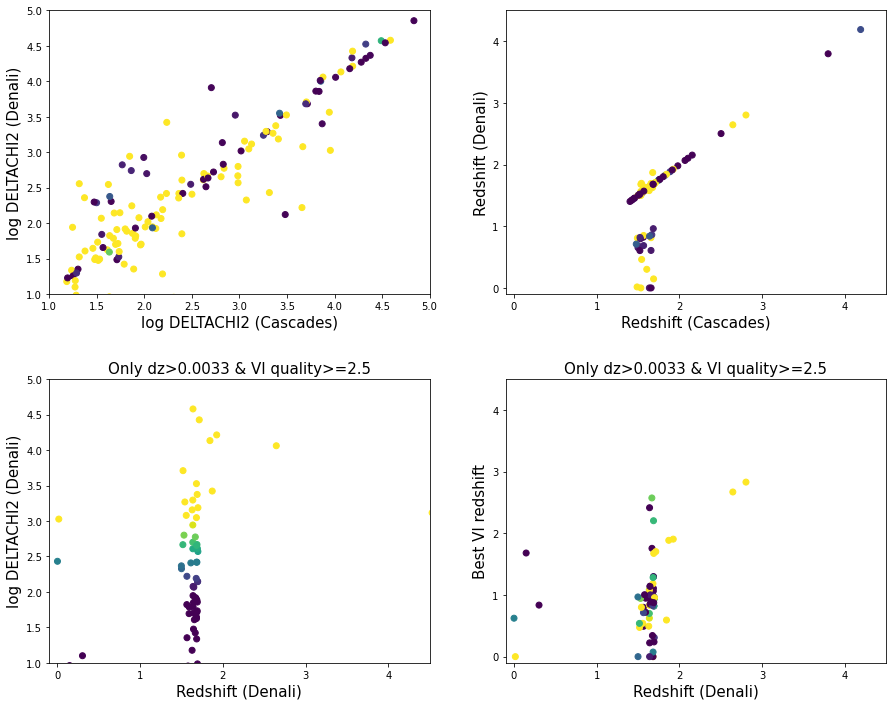

In [24]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,2,1)
plt.scatter(np.log10(final_match_catalog['DELTACHI2_cascades']),np.log10(final_match_catalog['DELTACHI2_denali']),c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(1,5)
plt.ylim(1,5)
plt.xlabel('log DELTACHI2 (Cascades)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,2)
plt.scatter(final_match_catalog['Z_cascades'],final_match_catalog['Z'],c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(-0.1,4.5)
plt.ylim(-0.1,4.5)
plt.xlabel('Redshift (Cascades)',fontsize=15)
plt.ylabel('Redshift (Denali)',fontsize=15)
plt.subplot(2,2,3)
plt.scatter(cut_catalog['Z'],np.log10(cut_catalog['DELTACHI2_denali']),c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.xlim(-0.1,4.5)
plt.ylim(1,5)
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,4)
plt.scatter(cut_catalog['Z'],cut_catalog['best_z'],c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlim(-0.1,4.5)
plt.ylim(-0.1,4.5)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('Best VI redshift',fontsize=15)

In [25]:
for i in range(0,len(index)):
    print(i,targetid[index[i]],fiberid[index[i]],LRG_tile[index[i]],np.array(cut_catalog['Redrock_z'])[index[i]])


0 39633351648215289 2726 80607 -7.325714346821059e-05
1 39633203044027868 1115 80676 0.01598455681602249
2 39627815557012511 2260 80669 0.14655359549946823
3 39633071229633535 2016 80678 0.3023115793498508
4 39633004431152665 3319 80677 1.4981557359760715
5 39633207146058549 1114 80676 1.4994621885253456
6 39632955508786136 2664 80622 1.5162850079580443
7 39632955282293948 2916 80692 1.5181461056951724
8 39632955244546134 3478 80690 1.5296556449057863
9 39633080528404873 2665 80678 1.5401841332087762
10 39632950521757836 2665 80700 1.5567921059629533
11 39633207150250710 1112 80676 1.563916004368643
12 39633207150253719 1141 80676 1.5649943922504337
13 39633351644023960 2728 80607 1.5659904731669614
14 39633098983343592 1499 80679 1.5784028235156395
15 39633190620497955 62 80676 1.590955626768394
16 39632950194603485 3479 80690 1.5916412533355482
17 39628121854447882 524 80683 1.6125648947195097
18 39628516764944265 1098 80700 1.627763044598987
19 39633057191299602 400 80678 1.62895783